# Lennard Jones - NVE ensemble

Tutorial for a simple MD simulation of Lennard-Jones spheres operating under the microcanonical ensemble.

NOTE: This tutorial is an adaptation of Andrew Summers' LJ Tutorial located at
https://github.com/summeraz/chbe4830/blob/master/Assignment3/LJ-NVE.ipynb

NOTE: This tutorial has been adapted from the LJ tutorial located at https://bitbucket.org/glotzer/hoomd-examples.

NOTE: A detailed description of all HOOMD commands can be found at https://hoomd-blue.readthedocs.io/en/stable/.

## Initialize

Import the hoomd python package and the md component to execute MD simulations. Also import the `deprecated` component for outputting `hoomdxml` trajectory information. 

In [1]:
import hoomd
import hoomd.md
import hoomd.deprecated.dump

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [2]:
hoomd.context.initialize("")

HOOMD-blue 2.2.2-unknown DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 12/04/17
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


Initialize an $n$ by $n$ by $n$ simple cubic lattice of particles, where `a` represents the lattice constant. The lattice initializer by default creates all particles named type "A", and with 0 velocity.

In [3]:
lattice = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5)

notice(2): Group "all" created containing 125 particles


Initialize particle velocities from a Gaussian distribution.

In [4]:
import random
random.seed(1)
T_init = 0.1
for p in lattice.particles:
    p.velocity = (random.gauss(0, T_init), random.gauss(0, T_init), random.gauss(0, T_init))

## Define potential energy

$ V(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] $, where $r$ < $r$<sub>cut</sub>

In the Lennard-Jones system, pairs of particles closer than $r_\mathrm{cut}$ interact with this potential energy.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [5]:
nl = hoomd.md.nlist.cell(r_buff=0.6, check_period=1)

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [6]:
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)

Specify pair potential parameters for every pair of types in the simulation.

In [7]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [8]:
hoomd.md.integrate.mode_standard(dt=0.005)

Apply NVE integration using the Velocity-Verlet algorithm.

In [9]:
all = hoomd.group.all()
hoomd.md.integrate.nve(group=all)

## Write output

The `hoomd.analyze.log` method can be used to log a variety of system properties (see http://hoomd-blue.readthedocs.io/en/stable/module-hoomd-analyze.html#hoomd.analyze.log). Here we will periodically log the temperature of the system to a text file.

In [10]:
hoomd.analyze.log(filename="analyze.log",
                  quantities=['temperature'],
                  period=100,
                  overwrite=True)

Periodically write the particle configurations to a gsd file.

In [11]:
hoomd.dump.gsd("trajectory.gsd", period=2e4, group=all, overwrite=True)

From the `deprecated` module, output the `hoomdxml` trajectory data for easier interfacing with `MDTraj` later.

In [12]:
hoomd.deprecated.dump.xml(all, filename='traj.xml', period=2e4, vis=True)

## Run the simulation

Take 1,000,000 steps forward in time.

In [13]:
hoomd.run(1e6)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 256516 / 1000000 | TPS 25651.6 | ETA 00:00:28
Time 00:00:20 | Step 519219 / 1000000 | TPS 26270 | ETA 00:00:18
Time 00:00:30 | Step 774219 / 1000000 | TPS 25499.6 | ETA 00:00:08
Time 00:00:38 | Step 1000000 / 1000000 | TPS 26449.7 | ETA 00:00:00
Average TPS: 25947.5
---------
-- Neighborlist stats:
47564 normal updates / 10000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 39 / n_neigh_avg: 11.88
shortest rebuild period: 12
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 0 / n_max: 12 / n_avg: 4.62963
** run complete **


## Examine the output

Use matplotlib to plot the temperature vs time step.

In [14]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='analyze.log', skip_header=True);

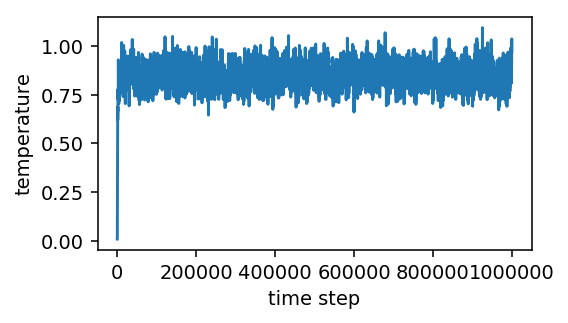

In [15]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

Examine how the system configuration evolves over time. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://bitbucket.org/glotzer/hoomd-examples) repository and designed only to render these examples.

In [16]:
#import ex_render
#ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');

Now lets analyze the trajectory a bit more. Using the `MDTraj` python package, we can analyze the system as it evolves over time and calculate some interesting properties. In this example, we will calculate the radial distribution function (RDF).

In [18]:
import mdtraj as md

Lets load in two of our hoomdxml trajectories. One near the beginning when it was more solid, and one near the end of the simulation, when it was a liquid.

In [30]:
more_solid = md.load_hoomdxml(filename="./traj.xml.0000000000.xml")
less_solid = md.load_hoomdxml(filename="./traj.xml.0000980000.xml")

In [32]:
print(more_solid)
print(less_solid)

<mdtraj.Trajectory with 1 frames, 125 atoms, 125 residues, and unitcells>
<mdtraj.Trajectory with 1 frames, 125 atoms, 125 residues, and unitcells>


Lets calculate the RDF's

In [49]:
#r_solid, g_r_solid = md.compute_rdf(more_solid, [[1,2]])

In [50]:
#r_solid